In [1]:
## IS722 - Iteration 4
## UPI: xnin394
## Name: Xin Ning
## Date: May 2024
## Note: run 'pip install ...' and restart the kernel.

In [2]:
# pip install -U seaborn

In [3]:
# pip install statsmodels

In [4]:
# pip install scikit-learn

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import log
from pyspark.sql.functions import when
from pyspark.sql.functions import rand
from pyspark.sql.functions import col, round
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassificationModel, DecisionTreeClassifier, RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve, auc, recall_score, confusion_matrix

In [6]:
spark = SparkSession.builder \
    .appName("data_analysis") \
    .getOrCreate()


df1_1 = spark.read.csv("Jan_transaction.csv", header=True, inferSchema=True)
df1_2 =  spark.read.csv("Jan_gps.csv", header=True, inferSchema=True)
df2 = spark.read.csv("Feb.csv", header=True, inferSchema=True)
df3 = spark.read.csv("Mar_m.csv", header=True, inferSchema=True)

## 3.4 
join_condition = df1_1['transaction_id'] == df1_2['transaction_id2']
df1 = df1_1.join(df1_2, join_condition, 'inner')
## adjust the order in different df
df1 = df1.select("transaction_id", "fraud", "card_number", "issue_year", "days_since_last_transaction", "repeat_retailer", "used_chip", "used_pin_number", "online_order", "single_transaction_mean", "transaction_amount", "distance_from_home", "distance_from_last_transaction")
df2 = df2.select("transaction_id", "fraud", "card_number", "issue_year", "days_since_last_transaction", "repeat_retailer", "used_chip", "used_pin_number", "online_order", "single_transaction_mean", "transaction_amount", "distance_from_home", "distance_from_last_transaction")
df3 = df3.select("transaction_id", "fraud", "card_number", "issue_year", "days_since_last_transaction", "repeat_retailer", "used_chip", "used_pin_number", "online_order", "single_transaction_mean", "transaction_amount", "distance_from_home", "distance_from_last_transaction")

data_df = df1.union(df2).union(df3)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/12 13:25:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/12 13:25:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
data_df.count()

737926

In [8]:
len(data_df.columns)

13

In [9]:
summary = data_df.describe().toPandas()
print(summary)

24/05/12 13:25:57 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


  summary transaction_id                fraud          card_number  \
0   count         737926               737926               737926   
1    mean           None  0.10555936503118199                 None   
2  stddev           None  0.30727302750835644                 None   
3     min  A000004871869                    0  6222-00000014256363   
4     max  Z999970667182                    1  6222-99999684628664   

           issue_year days_since_last_transaction      repeat_retailer  \
0              737926                      737926               737926   
1  2020.5074248637397           25.96424031677973   0.8818648482368151   
2  2.2890205092986498          15.531991706470224  0.32276830522791505   
3                2017                           0                    0   
4                2024                          77                    1   

             used_chip      used_pin_number         online_order  \
0               737926               737792               737926  

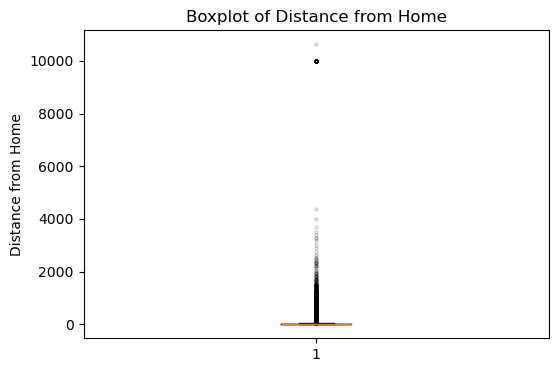

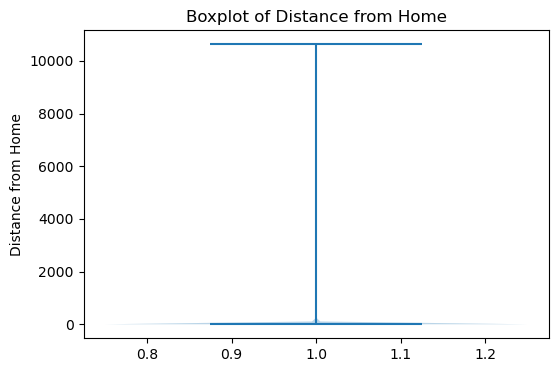

In [10]:
## 2.3
distance_from_home_values = data_df.select("distance_from_home").rdd.flatMap(lambda x: x).collect()

## box plot
plt.figure(figsize=(6, 4))
plt.boxplot(distance_from_home_values, flierprops=dict(marker='o', markersize=2, alpha=0.2))
plt.title('Boxplot of Distance from Home')
plt.ylabel('Distance from Home')
plt.show()
## voilin plot
plt.figure(figsize=(6, 4))
plt.violinplot(distance_from_home_values)
plt.title('Boxplot of Distance from Home')
plt.ylabel('Distance from Home')
plt.show()



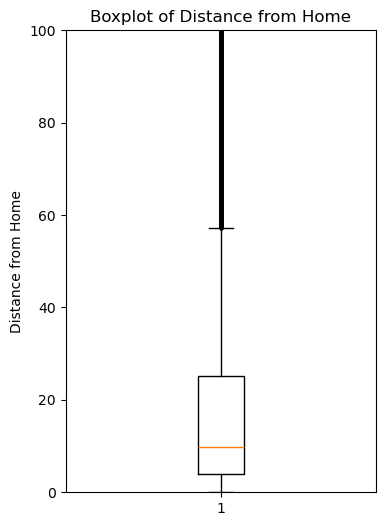

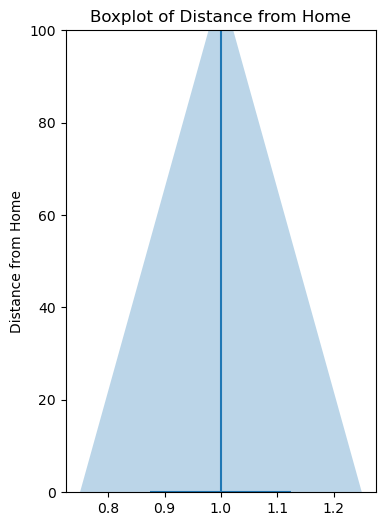

In [11]:
## box plot
plt.figure(figsize=(4, 6))
plt.boxplot(distance_from_home_values, flierprops=dict(marker='o', markersize=2, alpha=0.2))
plt.title('Boxplot of Distance from Home')
plt.ylabel('Distance from Home')
plt.ylim(0, 100)
plt.show()
# voilin plot
plt.figure(figsize=(4, 6))
plt.violinplot(distance_from_home_values)
plt.title('Boxplot of Distance from Home')
plt.ylabel('Distance from Home')
plt.ylim(0, 100)
plt.show()

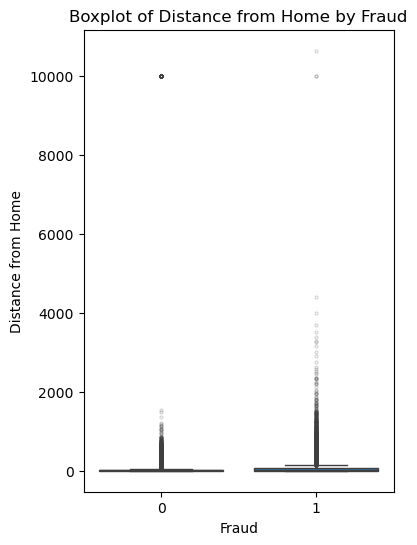

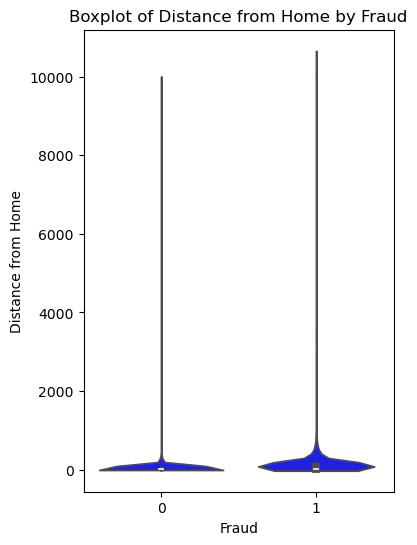

In [12]:
df = data_df.select("fraud", "distance_from_home").toPandas()

## box plot
plt.figure(figsize=(4, 6))
sns.boxplot(x='fraud', y='distance_from_home', data=df, flierprops=dict(marker='o', markersize=2, alpha=0.2))
plt.title('Boxplot of Distance from Home by Fraud')
plt.xlabel('Fraud')
plt.ylabel('Distance from Home')
plt.show()

# violin plot
plt.figure(figsize=(4, 6))
sns.violinplot(x='fraud', y='distance_from_home', data=df, color='blue')
plt.title('Boxplot of Distance from Home by Fraud')
plt.xlabel('Fraud')
plt.ylabel('Distance from Home')
plt.show()

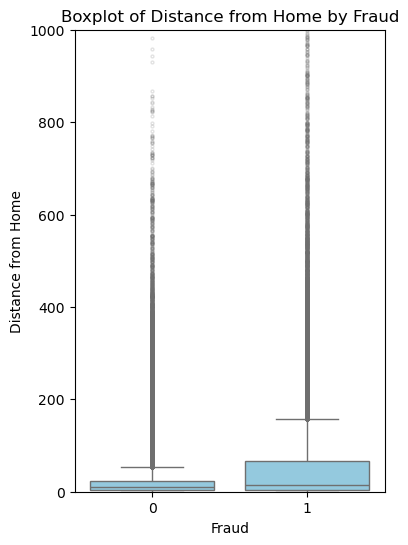

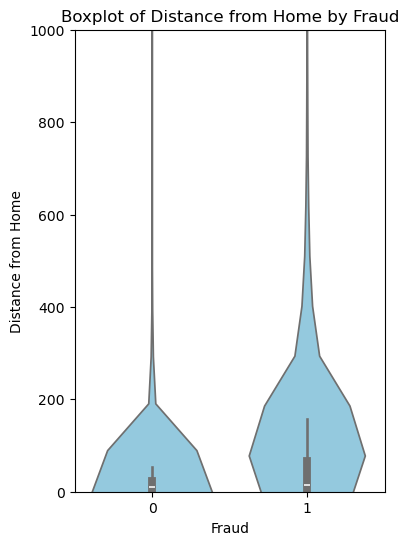

In [13]:
## box plot
plt.figure(figsize=(4, 6))
sns.boxplot(x='fraud', y='distance_from_home', data=df, color='skyblue', flierprops=dict(marker='o', markersize=2, alpha=0.2))
plt.title('Boxplot of Distance from Home by Fraud')
plt.xlabel('Fraud')
plt.ylabel('Distance from Home')
plt.ylim(0, 1000)
plt.show()

# violin plot
plt.figure(figsize=(4, 6))
sns.violinplot(x='fraud', y='distance_from_home', data=df, color='skyblue')
plt.title('Boxplot of Distance from Home by Fraud')
plt.xlabel('Fraud')
plt.ylabel('Distance from Home')
plt.ylim(0, 1000)
plt.show()

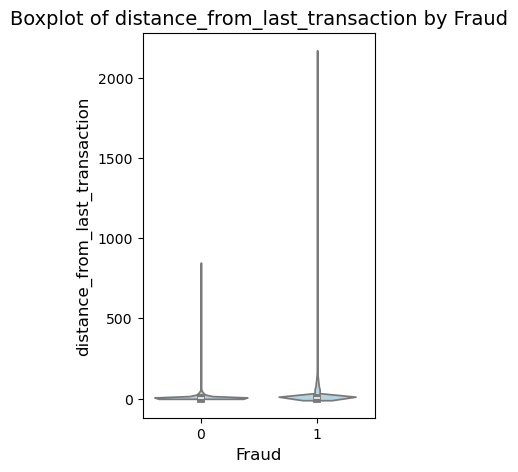

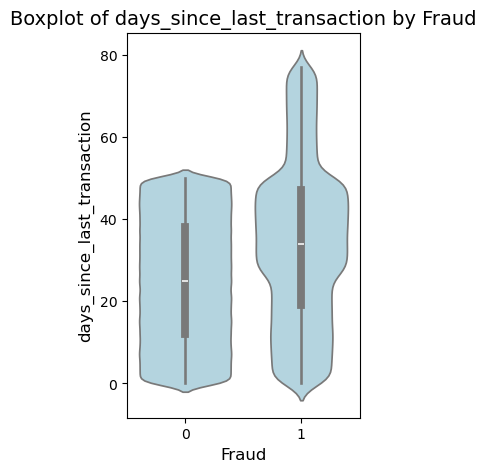

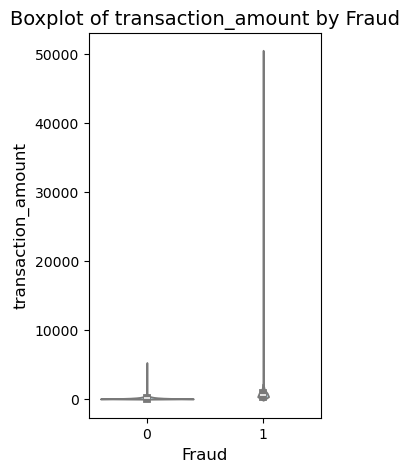

In [14]:
# distance_from_last_transaction
df = data_df.select("fraud", "distance_from_last_transaction").toPandas()
plt.figure(figsize=(3, 5))
sns.violinplot(x='fraud', y='distance_from_last_transaction', data=df, color='lightblue')
plt.title('Boxplot of distance_from_last_transaction by Fraud', fontsize=14)
plt.xlabel('Fraud', fontsize=12)
plt.ylabel('distance_from_last_transaction', fontsize=12)
plt.show()

# days_since_last_transaction
df = data_df.select("fraud", "days_since_last_transaction").toPandas()
plt.figure(figsize=(3, 5))
sns.violinplot(x='fraud', y='days_since_last_transaction', data=df, color='lightblue')
plt.title('Boxplot of days_since_last_transaction by Fraud', fontsize=14)
plt.xlabel('Fraud', fontsize=12)
plt.ylabel('days_since_last_transaction', fontsize=12)
plt.show()

# transaction_amount
df = data_df.select("fraud", "transaction_amount").toPandas()
plt.figure(figsize=(3, 5))
sns.violinplot(x='fraud', y='transaction_amount', data=df, color='lightblue')
plt.title('Boxplot of transaction_amount by Fraud', fontsize=14)
plt.xlabel('Fraud', fontsize=12)
plt.ylabel('transaction_amount', fontsize=12)
plt.show()

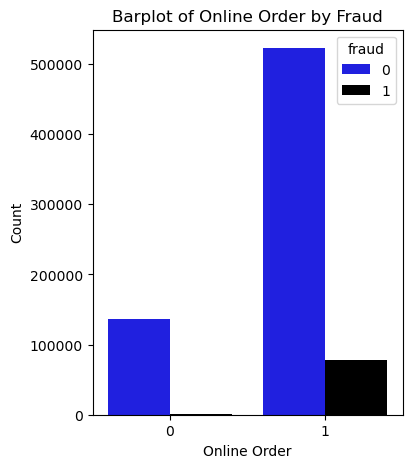

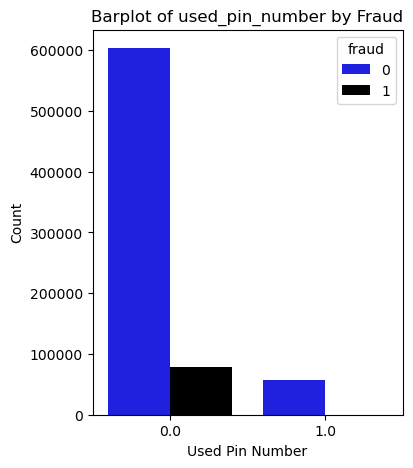

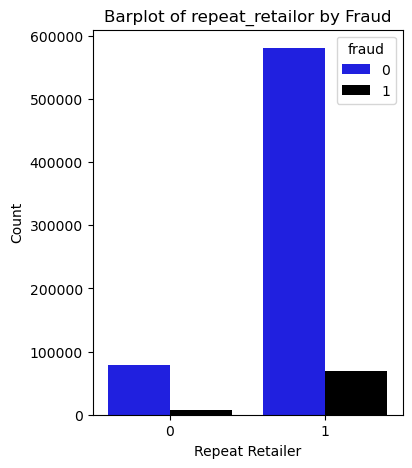

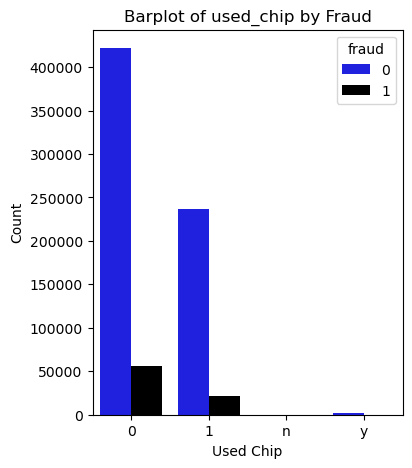

In [15]:
df = data_df.select("fraud", "online_order").toPandas()
plt.figure(figsize=(4, 5))
sns.countplot(x='online_order', hue='fraud', data=df, palette={0: "blue", 1: "black"} )
plt.title('Barplot of Online Order by Fraud')
plt.xlabel('Online Order')
plt.ylabel('Count')
plt.show()


df = data_df.select("fraud", "used_pin_number").toPandas()
plt.figure(figsize=(4, 5))
sns.countplot(x='used_pin_number', hue='fraud', data=df, palette={0: "blue", 1: "black"} )
plt.title('Barplot of used_pin_number by Fraud')
plt.xlabel('Used Pin Number')
plt.ylabel('Count')
plt.show()

df = data_df.select("fraud", "repeat_retailer").toPandas()
plt.figure(figsize=(4, 5))
sns.countplot(x='repeat_retailer', hue='fraud', data=df, palette={0: "blue", 1: "black"} )
plt.title('Barplot of repeat_retailor by Fraud')
plt.xlabel('Repeat Retailer')
plt.ylabel('Count')
plt.show()

df = data_df.select("fraud", "used_chip").toPandas()
plt.figure(figsize=(4, 5))
sns.countplot(x='used_chip', hue='fraud', data=df, palette={0: "blue", 1: "black"} )
plt.title('Barplot of used_chip by Fraud')
plt.xlabel('Used Chip')
plt.ylabel('Count')
plt.show()

In [16]:
# 3.1
data_df = data_df.drop('transaction_id', 'card_number')
# data_df.show()

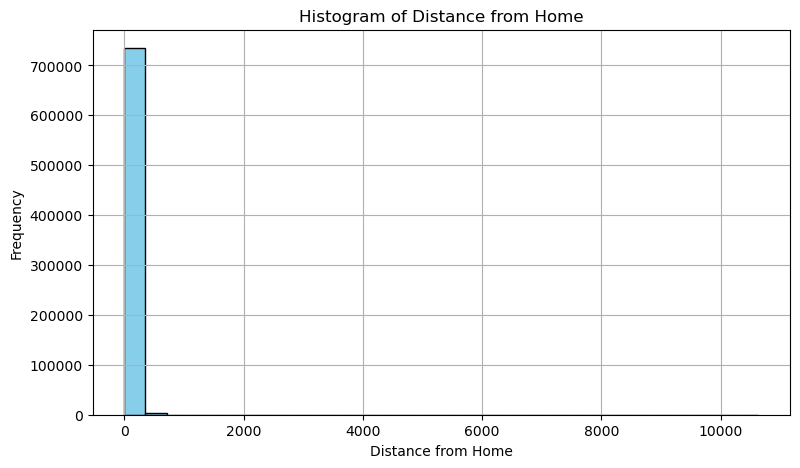

In [17]:
## 3.2
distance_from_home_values = data_df.select("distance_from_home").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(9, 5))
plt.hist(distance_from_home_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Distance from Home')
plt.xlabel('Distance from Home')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

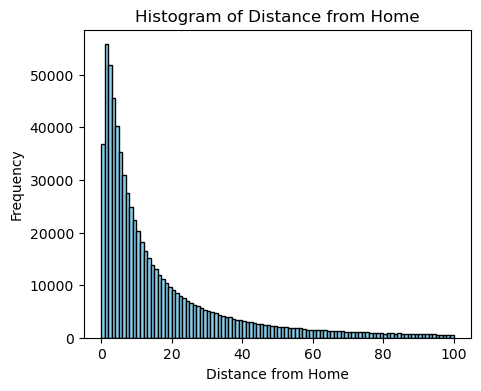

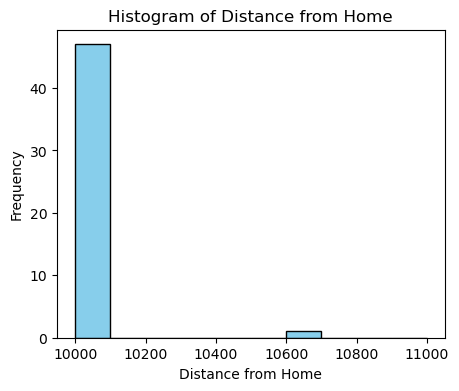

In [18]:
plt.figure(figsize=(5, 4))
plt.hist(distance_from_home_values, bins=100, range=(0, 100), color='skyblue', edgecolor='black')
plt.title('Histogram of Distance from Home')
plt.xlabel('Distance from Home')
plt.ylabel('Frequency')
# plt.xlim(0, 100)
plt.show()

plt.figure(figsize=(5, 4))
plt.hist(distance_from_home_values, range=(9998, 11000), color='skyblue', edgecolor='black')
plt.title('Histogram of Distance from Home')
plt.xlabel('Distance from Home')
plt.ylabel('Frequency')
plt.show()

In [19]:
## handling outliers
data_df = data_df.withColumn("distance_from_home", when(data_df["distance_from_home"] == 9999, 2).otherwise(data_df["distance_from_home"]))
## handling extreme values
data_df = data_df.filter(data_df["distance_from_home"] <= 10000)

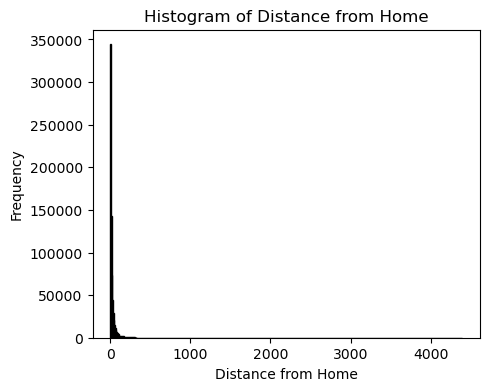

In [20]:
distance_from_home_values = data_df.select("distance_from_home").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(5, 4))
plt.hist(distance_from_home_values, bins=500, color='skyblue', edgecolor='black')
plt.title('Histogram of Distance from Home')
plt.xlabel('Distance from Home')
plt.ylabel('Frequency')
plt.show()

In [21]:
## handling missing values
## use Chi-Square Test and fill the missing value accordong to another variable
df = data_df.select("used_pin_number", "online_order").toPandas()
df = pd.DataFrame(df)

cross_table = pd.crosstab(df['used_pin_number'], df['online_order'])
chi2, p, dof, expected = chi2_contingency(cross_table)
print('Chi Square Value:', chi2)
print('p-value:', p)
print(cross_table)

Chi Square Value: 75178.2415793383
p-value: 0.0
online_order          0       1
used_pin_number                
0.0              102566  578585
1.0               34978   21662


In [22]:
data_df = data_df.withColumn("used_pin_number", 
    when(data_df["online_order"] == 1, 0)
    .otherwise(1)
)

In [23]:
## * 3.3 construct the data *
data_df = data_df.withColumn("ratio_to_median_purchase_price", round(col("transaction_amount") / col("single_transaction_mean"), 2))

In [24]:
## * 3.5 format the data as required *
data_df = data_df.withColumn("used_chip", 
    when(data_df["used_chip"] == "y", 1)
    .when(data_df["used_chip"] == "n", 0)
    .when(data_df["used_chip"] == "1", 1)
    .when(data_df["used_chip"] == "0", 0)                             
    .otherwise(0)
)

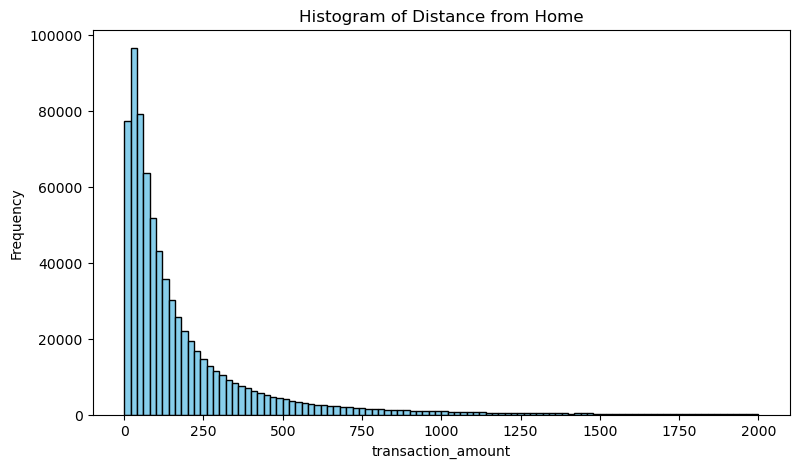

In [25]:
## * 4.2 project the data *
## log transformation for variable transaction_amount
transaction_amount_values = data_df.select("transaction_amount").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(9, 5))
plt.hist(transaction_amount_values, bins=100, range=(0, 2000), color='skyblue', edgecolor='black')
plt.title('Histogram of Distance from Home')
plt.xlabel('transaction_amount')
plt.ylabel('Frequency')
plt.show()

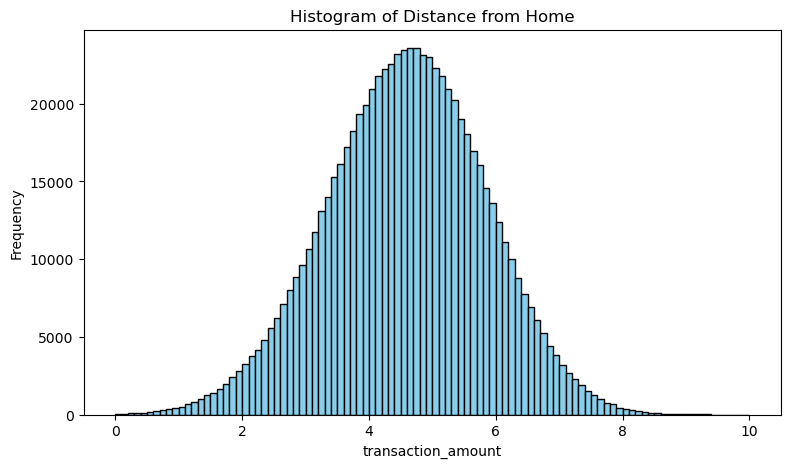

In [26]:
data_df = data_df.withColumn("log_transaction_amount", log(data_df["transaction_amount"]))

log_transaction_amount_values = data_df.select("log_transaction_amount").rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(9, 5))
plt.hist(log_transaction_amount_values, bins=100, range=(0, 10), color='skyblue', edgecolor='black')
plt.title('Histogram of Distance from Home')
plt.xlabel('transaction_amount')
plt.ylabel('Frequency')
plt.show()

In [27]:
## * 4.2 project the data *
## data discretization 
data_df = data_df.withColumn("days_since_last_transaction_category",
                             when(data_df["days_since_last_transaction"] <= 45, '1')
                             .when((data_df["days_since_last_transaction"] > 45), '2')
                             .otherwise(1))

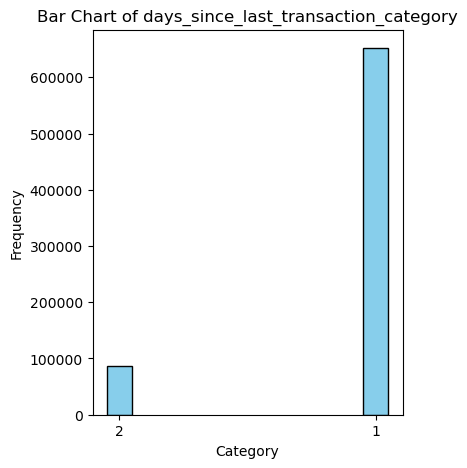

In [28]:
category_values = data_df.select("days_since_last_transaction_category").rdd.flatMap(lambda x: x).collect()
category_counts = {}
for category in set(category_values):
    category_counts[category] = category_values.count(category)
plt.figure(figsize=(4, 5))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue', edgecolor='black', width=0.1)
plt.title('Bar Chart of days_since_last_transaction_category')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

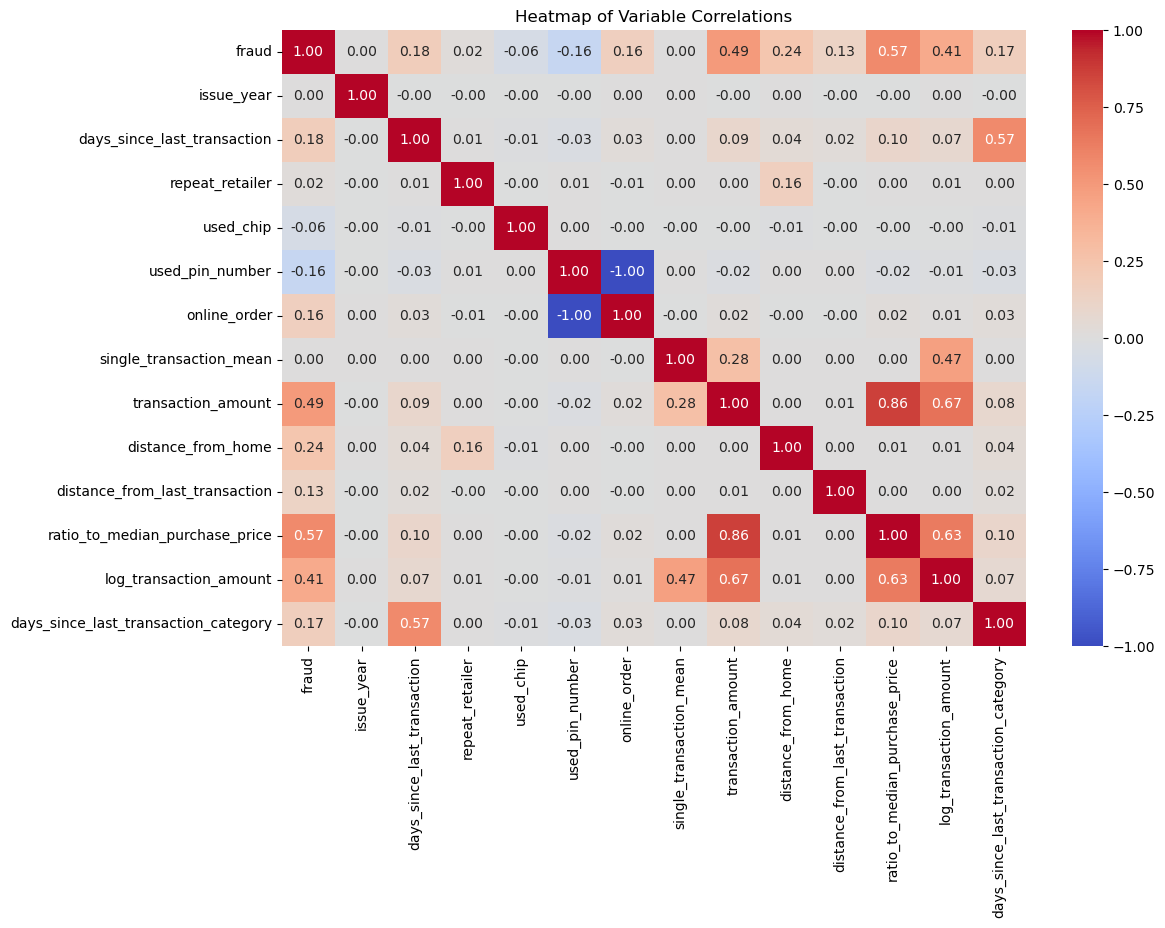

In [29]:
## * 4.1 reduce the data *
pandas_df = data_df.toPandas()
correlation_matrix = pandas_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Variable Correlations')
plt.show()

In [30]:
selected_df = data_df.select('distance_from_home', 'distance_from_last_transaction', 'online_order', 'transaction_amount', 'ratio_to_median_purchase_price', 'days_since_last_transaction', 'fraud')

In [31]:
data = selected_df

In [32]:
########### complete all the data preprocessing #############
summary = data.describe().toPandas()
print(summary)
########### complete all the data preprocessing #############

  summary  distance_from_home distance_from_last_transaction  \
0   count              737925                         737925   
1    mean  25.233874336986226                4.7713194860066   
2  stddev  55.858445062130286             19.077687334945253   
3     min              0.0049                     3.19213E-4   
4     max         4394.314607                    2160.499922   

         online_order  transaction_amount ratio_to_median_purchase_price  \
0              737925              737925                         737925   
1  0.8135623538977539  206.01691131321914             1.8051759054104382   
2  0.3894596972292426   356.7043849210584              2.689030061776277   
3                   0        0.2539031924                            0.0   
4                   1     50415.019394584                         266.69   

  days_since_last_transaction                fraud  
0                      737925               737925  
1          25.964259240437713  0.10555815292882068  

In [33]:
## * 6.3 build appropriate models and choose relevant parameters *
## * 7.1 create test designs *
## * 7.2 conduct data mining *

data = data.orderBy(rand())
feature_cols = ['distance_from_home', 'distance_from_last_transaction', 'online_order', 
                'transaction_amount', 'ratio_to_median_purchase_price', 
                'days_since_last_transaction']
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_with_features = vector_assembler.transform(data)

## undersampling
# fraud_count = data.filter(col("fraud") == 1).count()
# non_fraud_count = data.filter(col("fraud") == 0).count()
# undersampling_ratio = fraud_count / non_fraud_count
# undersampled_non_fraud_data = data.filter(col("fraud") == 0).sample(withReplacement=False, fraction=undersampling_ratio)
# undersampled_data = data.filter(col("fraud") == 1).unionAll(undersampled_non_fraud_data)
# undersampled_data = undersampled_data.orderBy(rand())

train_data, test_data = data_with_features.randomSplit([0.7, 0.3])

In [34]:
## logistics regression
lr = LogisticRegression(featuresCol="features", labelCol="fraud")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

## indicators
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="fraud")
roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Area Under ROC:", roc)

## predictions
predictions.select("fraud", "prediction", "probability").show(25)

## coef
coefficients = lr_model.coefficients
print("Coefficients:", coefficients)

intercept = lr_model.intercept
print("Intercept:", intercept)

24/05/12 13:26:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/12 13:26:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Accuracy: 0.9687738245072697
F1 Score: 0.9677143409838413
Area Under ROC: 0.9892608457123433
+-----+----------+--------------------+
|fraud|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.99999999993970...|
|    1|       1.0|[0.00716936264102...|
|    0|       0.0|[0.99903579436303...|
|    0|       0.0|[0.99970128825391...|
|    1|       1.0|[0.00641269033640...|
|    0|       0.0|[0.99307360877814...|
|    0|       0.0|[0.99912768755327...|
|    0|       0.0|[0.99940447329022...|
|    0|       0.0|[0.99491440037863...|
|    0|       0.0|[0.91376822628471...|
|    0|       0.0|[0.99848664638046...|
|    0|       0.0|[0.91370666921353...|
|    0|       0.0|[0.99849362519307...|
|    0|       0.0|[0.99909749344139...|
|    0|       0.0|[0.99999999993042...|
|    0|       0.0|[0.99926780047907...|
|    0|       0.0|[0.99901546463295...|
|    0|       0.0|[0.99879766140587...|
|    0|       0.0|[0.99891072670212...|
|    0|       0.0|[0.969209

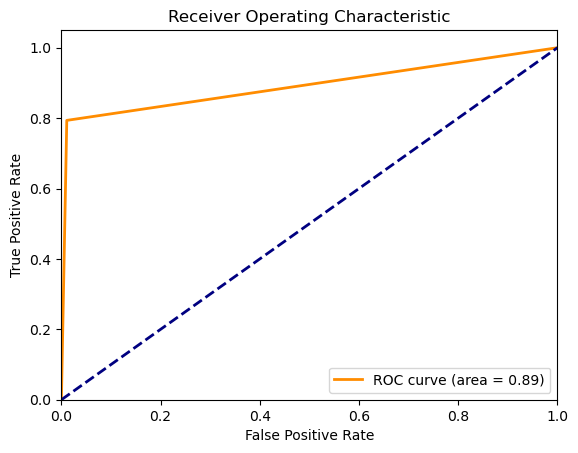

In [35]:
pred = predictions.toPandas()
y_test = pred['fraud']
y_pred = pred['prediction']


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

## ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

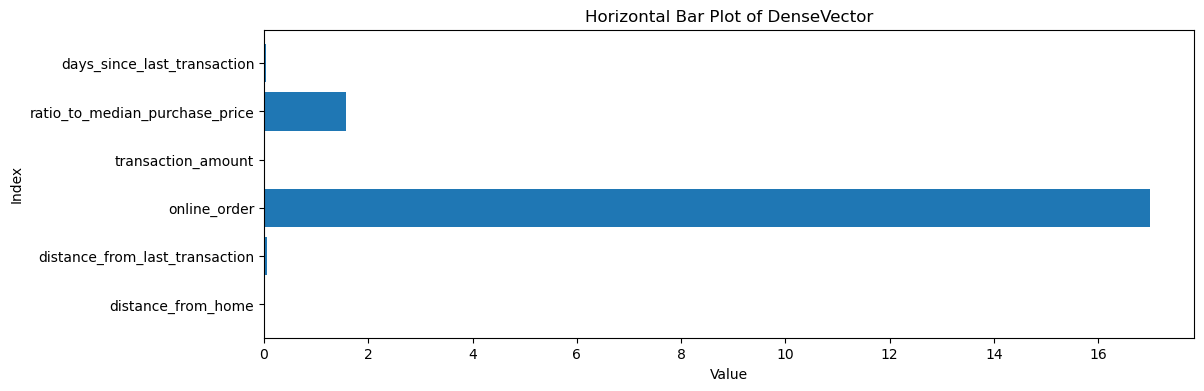

In [36]:
numpy_array = np.array(coefficients)

index = np.arange(len(numpy_array))
index_labels = ['distance_from_home', 'distance_from_last_transaction', 'online_order', 
                'transaction_amount', 'ratio_to_median_purchase_price', 
                'days_since_last_transaction']

# Variable Importance
plt.figure(figsize=(12, 4))
plt.barh(index, numpy_array)
plt.ylabel('Index')
plt.xlabel('Value')
plt.title('Horizontal Bar Plot of DenseVector')
plt.yticks(index, index_labels)
plt.show()

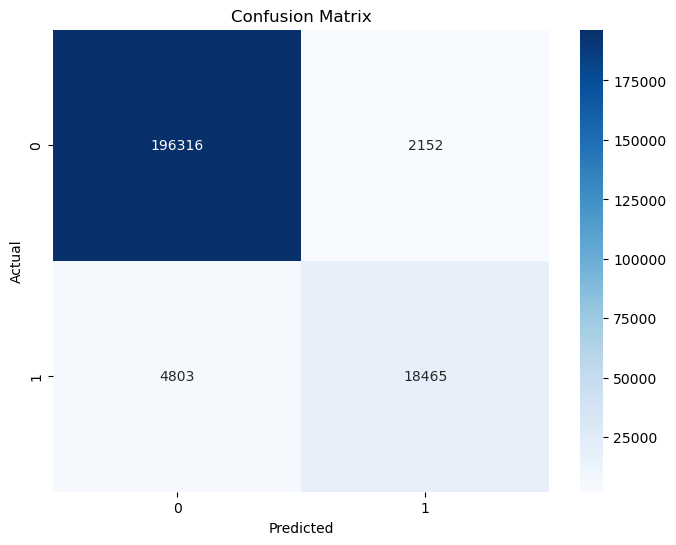

In [37]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

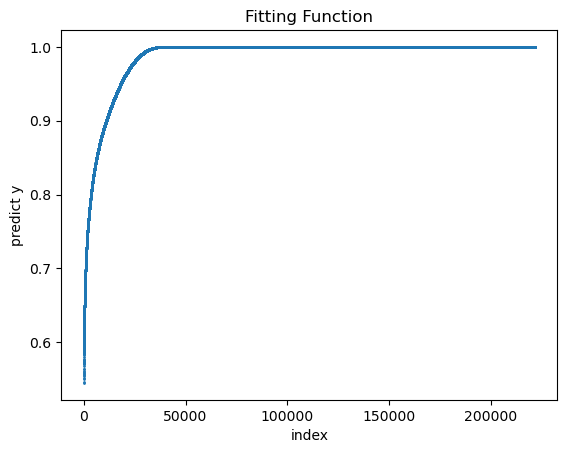

In [38]:
## Sigmoid 
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_regression(X, beta):
    z = np.dot(X, beta)
    return sigmoid(z)

X_np = test_data['distance_from_home', 'distance_from_last_transaction', 'online_order','transaction_amount', 
'ratio_to_median_purchase_price', 'days_since_last_transaction'].toPandas()
y_np = lr_model.coefficients

predictions = logistic_regression(X_np, y_np)
y = pd.DataFrame(predictions)
y = y.sort_values(by=0)
y_2 = test_data
x = list(range(len(y)))
fun_df = pd.concat([pd.DataFrame(x), y], axis=1)
plt.scatter(x ,y, s=1)
plt.title('Fitting Function')
plt.xlabel('index')
plt.ylabel('predict y')
plt.show()

Optimization terminated successfully.
         Current function value: 0.343511
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:               737925
Model:                          Logit   Df Residuals:                   737919
Method:                           MLE   Df Model:                            5
Date:                Sun, 12 May 2024   Pseudo R-squ.:                -0.01894
Time:                        13:27:19   Log-Likelihood:            -2.5349e+05
converged:                       True   LL-Null:                   -2.4877e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
distance_from_home                 0.0060   6.29e-05     95.146     

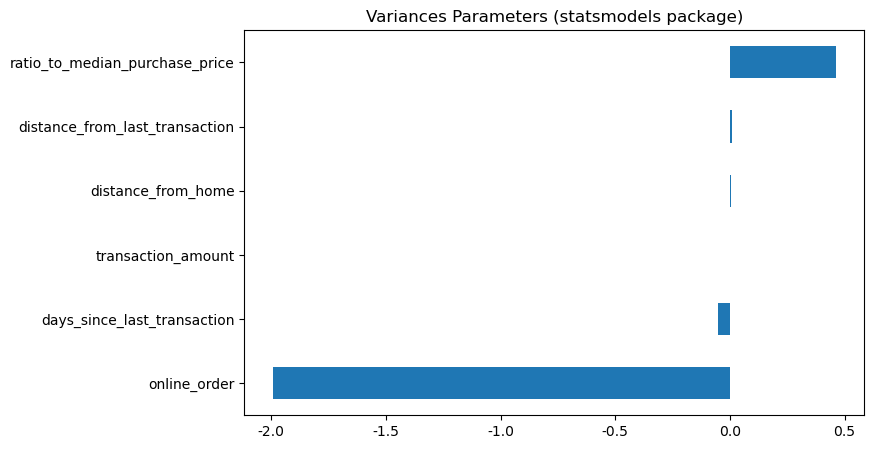

Predictions: [0.07099236 0.38471672 0.01862703 ... 0.01757266 0.07187362 0.29177127]


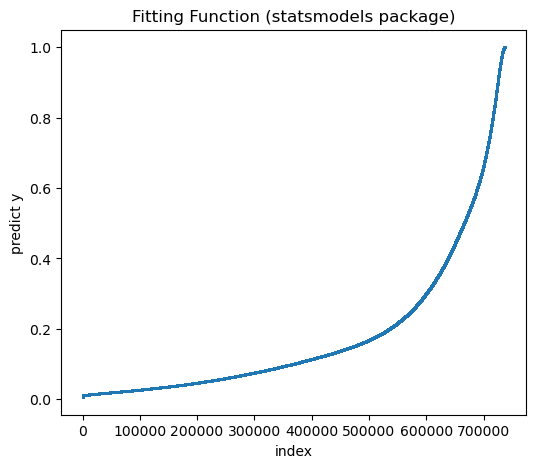

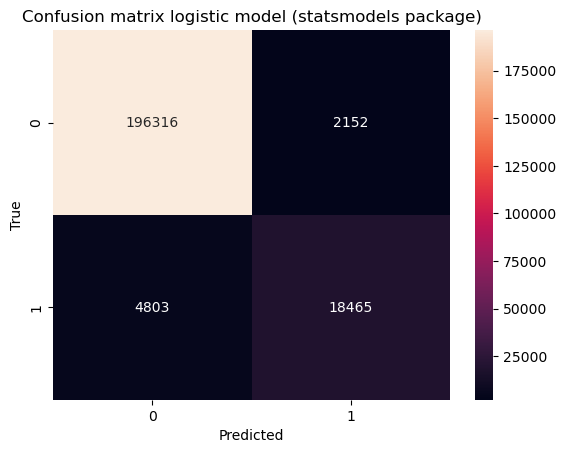

In [39]:
data_log = data.toPandas()
## logistic model
X = data_log[['distance_from_home', 'distance_from_last_transaction', 'online_order','transaction_amount', 
'ratio_to_median_purchase_price', 'days_since_last_transaction']]
y = data_log['fraud']
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

## visualization for Variances Importances
plt.rcParams['axes.unicode_minus'] = False
coef = pd.Series(result.params, index = X.columns, name = 'Var')
plt.figure(figsize=(8, 5))
coef.sort_values().plot(kind='barh')
plt.title('Variances Parameters (statsmodels package)')
plt.show()

## visualization for fitting pattern
X = pd.DataFrame(X)
X_np = X.to_numpy()
y_np = np.array(result.params)
predictions = logistic_regression(X_np, y_np)
print("Predictions:", predictions)
y = pd.DataFrame(predictions)
y = y.sort_values(by=0)
y_2 = X
x = list(range(len(y)))
fun_df = pd.concat([pd.DataFrame(x), y], axis=1)
plt.figure(figsize=(6, 5))
plt.scatter(x ,y , s=1)
plt.title('Fitting Function (statsmodels package)')
plt.xlabel('index')
plt.ylabel('predict y')
plt.show()

## visualization for confusion matrix
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix logistic model (statsmodels package)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [40]:
## Lasso
lasso = LinearRegression(featuresCol='features', labelCol='fraud', elasticNetParam=1.0)
lasso_model = lasso.fit(train_data)

# coef
print("Coefficients: " + str(lasso_model.coefficients))
print("Intercept: " + str(lasso_model.intercept))


predictions = lasso_model.transform(test_data)
predictions = predictions.withColumn("prediction", when(predictions["prediction"] > 0.43, 1.0).otherwise(0.0))

# predictions
predictions.select('features', 'fraud', 'prediction').show()

# indicator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

24/05/12 13:27:22 WARN Instrumentation: [0236f30f] regParam is zero, which might cause numerical instability and overfitting.
24/05/12 13:27:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [0.0013018092985279095,0.001978972614134412,0.11503553221162274,1.0678301165870217e-05,0.06466256651442177,0.002023296702159204]
Intercept: -0.20144250467035163
+--------------------+-----+----------+
|            features|fraud|prediction|
+--------------------+-----+----------+
|[0.0446,6.1957318...|    0|       0.0|
|[0.056879044,10.7...|    1|       1.0|
|[0.073584488,0.29...|    1|       1.0|
|[0.077463969,0.17...|    0|       0.0|
|[0.0907,0.4806263...|    0|       0.0|
|[0.091553313,11.0...|    0|       0.0|
|[0.0917,0.2271110...|    0|       0.0|
|[0.0937,0.1990847...|    0|       0.0|
|[0.100379655,0.39...|    0|       0.0|
|[0.10254251,19.12...|    0|       0.0|
|[0.103861331,0.99...|    0|       0.0|
|[0.1051,0.3972998...|    0|       0.0|
|[0.1076,0.1493047...|    0|       0.0|
|[0.1097,0.5502996...|    0|       0.0|
|[0.111153191,0.07...|    0|       0.0|
|[0.1119,7.3119013...|    0|       0.0|
|[0.112720879,3.70...|    0|       0.0|
|[0.1183,1.4029844...|   

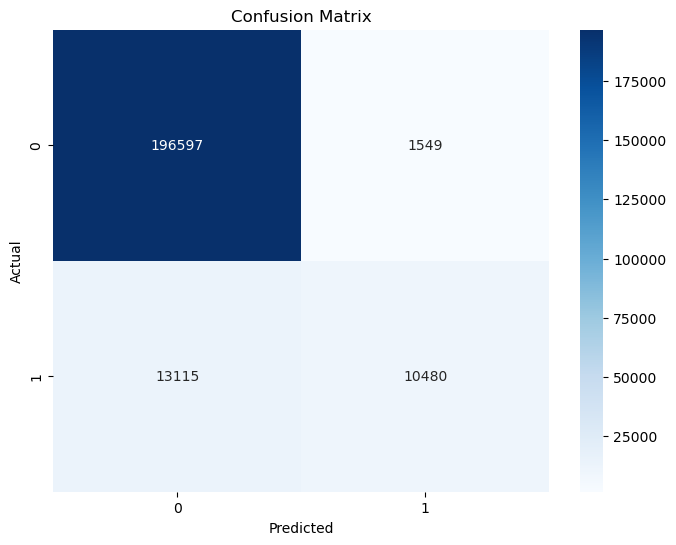

In [41]:
pred = predictions.toPandas()
y_test = pred['fraud']
y_pred = pred['prediction']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

24/05/12 13:27:36 WARN Instrumentation: [561995fd] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [0.0012694654471496524,0.002042781359917584,0.11570548220191054,-2.418224035917994e-05,0.06641244057042221,0.002075003828107506]
Intercept: -0.1989895463892892
Accuracy: 0.9241433429244049
F1 Score: 0.9078529497404567


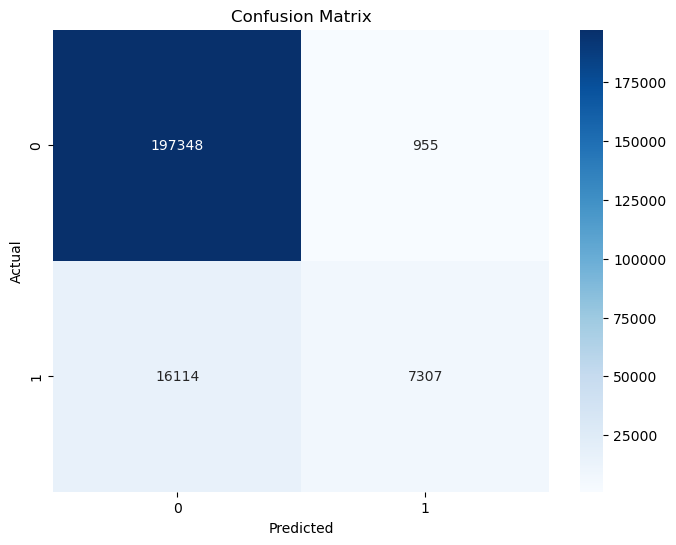

In [42]:
## Linear regression

lr = LinearRegression(featuresCol='features', labelCol='fraud')
lr_model = lr.fit(train_data)

# coef
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

# predictions
predictions = lr_model.transform(test_data)
predictions = predictions.withColumn("prediction", when(predictions["prediction"] > 0.5, 1.0).otherwise(0.0))

# indicator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)


pred = predictions.toPandas()
y_test = pred['fraud']
y_pred = pred['prediction']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

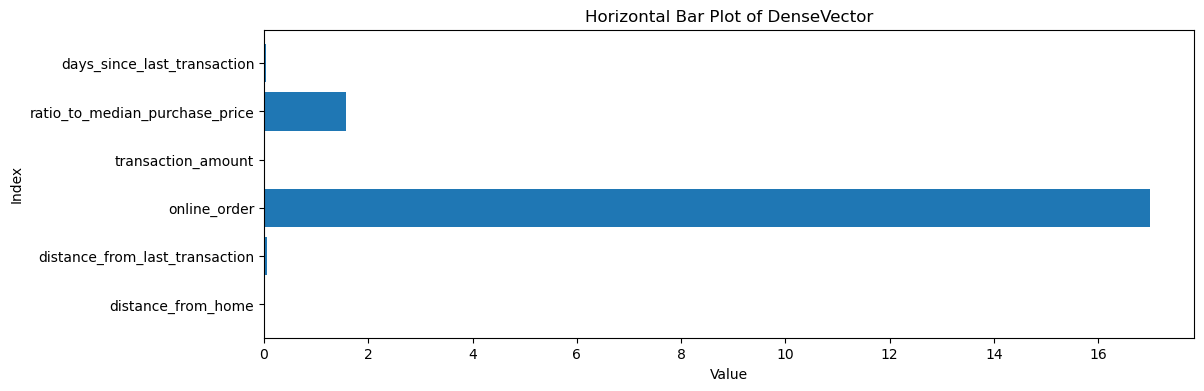

In [43]:
lr_model.coefficients

numpy_array = np.array(coefficients)

index = np.arange(len(numpy_array))
index_labels = ['distance_from_home', 'distance_from_last_transaction', 'online_order', 
                'transaction_amount', 'ratio_to_median_purchase_price', 
                'days_since_last_transaction']


plt.figure(figsize=(12, 4))
plt.barh(index, numpy_array)
plt.ylabel('Index')
plt.xlabel('Value')
plt.title('Horizontal Bar Plot of DenseVector')
plt.yticks(index, index_labels)
plt.show()

In [44]:
## decision tree
dt = DecisionTreeClassifier(featuresCol='features', labelCol='fraud')
dt_model = dt.fit(train_data)

predictions = dt_model.transform(test_data)
predictions.select('features', 'fraud', 'prediction').show()

# indicator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

print(dt_model.toDebugString)

+--------------------+-----+----------+
|            features|fraud|prediction|
+--------------------+-----+----------+
|[0.0446,6.1957318...|    0|       0.0|
|[0.056879044,10.7...|    1|       1.0|
|[0.073584488,0.29...|    1|       1.0|
|[0.077463969,0.17...|    0|       0.0|
|[0.0907,0.4806263...|    0|       0.0|
|[0.091553313,11.0...|    0|       0.0|
|[0.0917,0.2271110...|    0|       0.0|
|[0.0937,0.1990847...|    0|       0.0|
|[0.100379655,0.39...|    0|       0.0|
|[0.10254251,19.12...|    0|       0.0|
|[0.103861331,0.99...|    0|       0.0|
|[0.1051,0.3972998...|    0|       0.0|
|[0.1076,0.1493047...|    0|       0.0|
|[0.1097,0.5502996...|    0|       0.0|
|[0.111153191,0.07...|    0|       0.0|
|[0.1119,7.3119013...|    0|       0.0|
|[0.113028849,1.46...|    0|       0.0|
|[0.1216,3.3369612...|    0|       0.0|
|[0.1244,1.0798878...|    0|       0.0|
|[0.12710626,5.614...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows

Accuracy: 0.98

Number of nodes: 29
Depth of tree: 5
Feature importances: (6,[0,1,2,3,4,5],[0.09680161241666976,0.018204269662372704,0.18523633053380092,1.6342972125621128e-05,0.695703755337226,0.004037689077805088])
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0       195562         2789
Actual 1         1542        21863


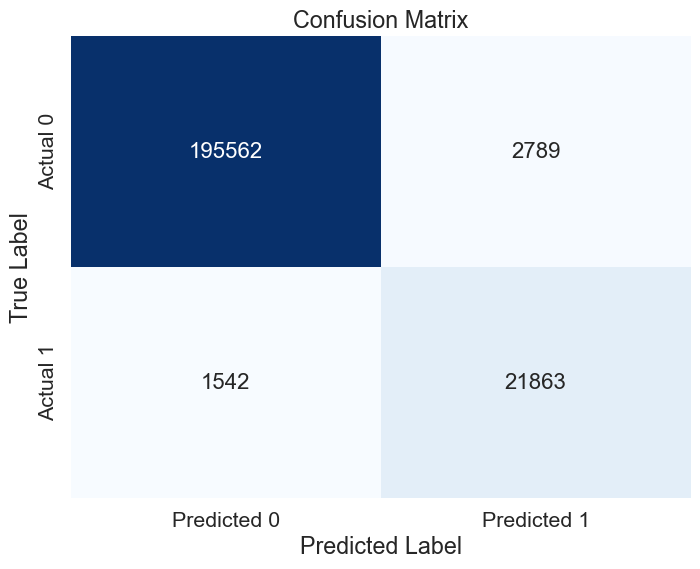

In [45]:
print("Number of nodes:", dt_model.numNodes)
print("Depth of tree:", dt_model.depth)
print("Feature importances:", dt_model.featureImportances)

predictions_pd = predictions.select('fraud', 'prediction').toPandas()

cm = confusion_matrix(predictions_pd['fraud'], predictions_pd['prediction'])
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 16}, 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [46]:
## randome forest
rf = RandomForestClassifier(featuresCol='features', labelCol='fraud')
rf_model = rf.fit(train_data)

# predictions
predictions = rf_model.transform(test_data)
predictions.select('features', 'fraud', 'prediction').show()

# indicator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

+--------------------+-----+----------+
|            features|fraud|prediction|
+--------------------+-----+----------+
|[0.0446,6.1957318...|    0|       0.0|
|[0.056879044,10.7...|    1|       1.0|
|[0.073584488,0.29...|    1|       1.0|
|[0.077463969,0.17...|    0|       0.0|
|[0.0907,0.4806263...|    0|       0.0|
|[0.091553313,11.0...|    0|       0.0|
|[0.0917,0.2271110...|    0|       0.0|
|[0.0937,0.1990847...|    0|       0.0|
|[0.100379655,0.39...|    0|       0.0|
|[0.10254251,19.12...|    0|       0.0|
|[0.103861331,0.99...|    0|       0.0|
|[0.1051,0.3972998...|    0|       0.0|
|[0.1076,0.1493047...|    0|       0.0|
|[0.1097,0.5502996...|    0|       0.0|
|[0.111153191,0.07...|    0|       0.0|
|[0.1119,7.3119013...|    0|       0.0|
|[0.112720879,3.70...|    0|       0.0|
|[0.1183,1.4029844...|    0|       0.0|
|[0.1239,0.9603457...|    0|       0.0|
|[0.1247,0.5435475...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows

Accuracy: 0.97

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0       195757         2447
Actual 1         2664        20906


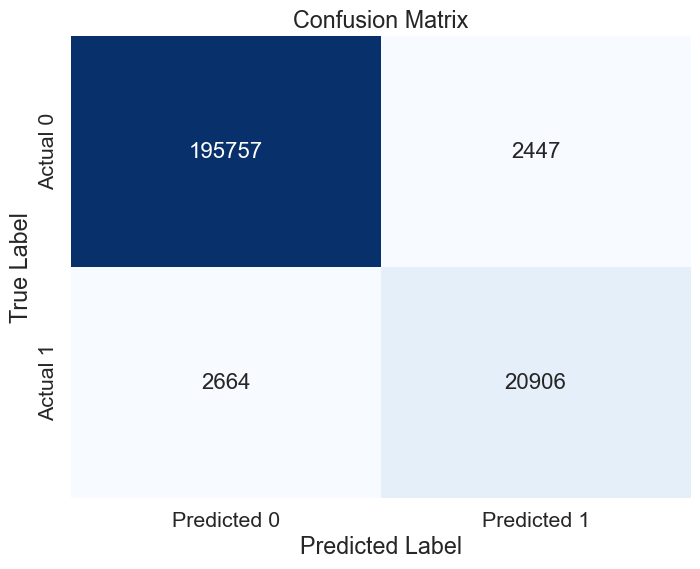

In [47]:
predictions_pd = predictions.select('fraud', 'prediction').toPandas()

cm = confusion_matrix(predictions_pd['fraud'], predictions_pd['prediction'])
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 16},  
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [48]:
## END